In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Data Pre-processing

In [6]:
# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0
y_train_full, y_test = to_categorical(y_train_full), to_categorical(y_test)

# CIFAR-10 class labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Total number of images in CIFAR-10 dataset
total_train_images = y_train_full.shape[0]
total_test_images = y_test.shape[0]

# Counting the number of images per class in the training and test datasets
class_counts_train = np.sum(y_train_full, axis=0)
class_counts_test = np.sum(y_test, axis=0)

# Creating df for easy visualisation
data_summary = pd.DataFrame({
    "Class Name": class_names,
    "Training Images": class_counts_train,
    "Test Images": class_counts_test
})

data_summary.loc["Total"] = ["Total", total_train_images, total_test_images]

print(data_summary)

       Class Name  Training Images  Test Images
0        Airplane           5000.0       1000.0
1      Automobile           5000.0       1000.0
2            Bird           5000.0       1000.0
3             Cat           5000.0       1000.0
4            Deer           5000.0       1000.0
5             Dog           5000.0       1000.0
6            Frog           5000.0       1000.0
7           Horse           5000.0       1000.0
8            Ship           5000.0       1000.0
9           Truck           5000.0       1000.0
Total       Total          50000.0      10000.0


In [7]:
total_images = int(total_train_images + total_test_images)
total_classes = len(class_names)

print(f"Total number of images is {total_images} and total classes is {total_classes}.")


Total number of images is 60000 and total classes is 10.


In [8]:
# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


In [11]:
image_resolution = x_train[0].shape[:2]
print(f"Resolution of images in the dataset: {image_resolution[0]}x{image_resolution[1]} pixels")

Resolution of images in the dataset: 32x32 pixels


In [10]:
# Total number of images in each set
num_train_images = x_train.shape[0]
num_val_images = x_val.shape[0]
num_test_images = x_test.shape[0]


print(f"Number of images in the training set: {num_train_images}")
print(f"Number of images in the validation set: {num_val_images}")
print(f"Number of images in the test set: {num_test_images}")

Number of images in the training set: 40000
Number of images in the validation set: 10000
Number of images in the test set: 10000


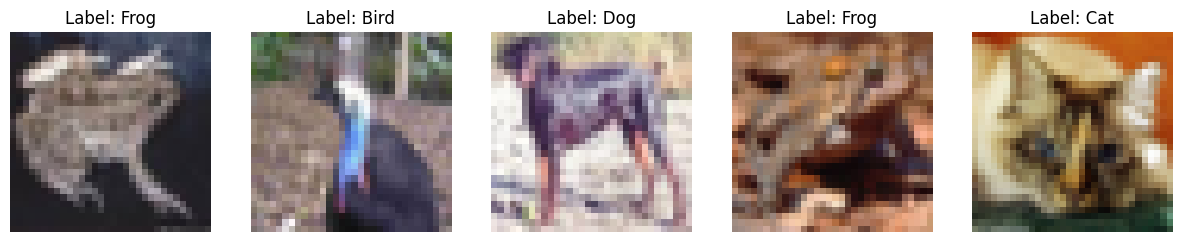

In [9]:
# displaying images
def display_images_with_labels(images, labels, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Label: {class_names[np.argmax(labels[i])]}")
        ax.axis('off')
    plt.show()

display_images_with_labels(x_train[:5], y_train[:5], class_names)

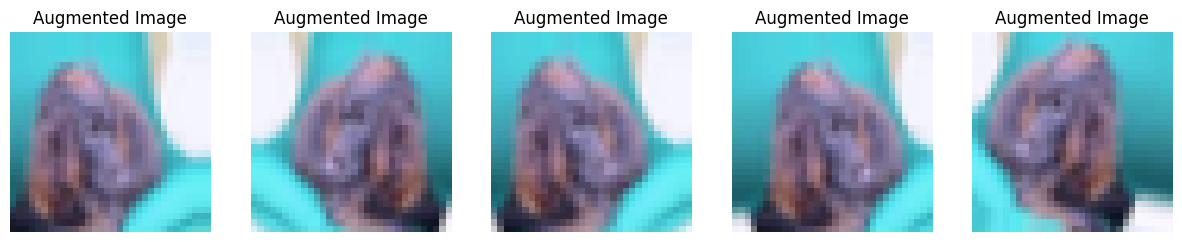

In [ ]:
# Data augmentation for training data
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = datagen.flow(x_train, y_train, batch_size=64)

# Random image selected and displayed
random_index = random.randint(0, len(x_train) - 1)
sample_image = np.expand_dims(x_train[random_index], 0)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    augmented_image = next(datagen.flow(sample_image, batch_size=1))[0]
    augmented_image = (augmented_image * 255).astype(np.uint8)
    ax.imshow(augmented_image)
    ax.set_title("Augmented Image")
    ax.axis('off')
plt.show()

#Defining Models

In [ ]:
# Model Definitions

# VGG-16 with BatchNorm and Dropout
def create_vgg16_improved():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# ResNet-18 with BatchNorm and Dropout
def create_resnet18():
    input = tf.keras.Input(shape=(32, 32, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    for _ in range(2):
        shortcut = x
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([shortcut, x])

    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)
    return model

# MobileNet with BatchNorm and Dropout
def create_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model


def create_resnet50(input_shape=(32, 32, 3), num_classes=10):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)

    return model

In [ ]:
# Instantiate models
vgg16_model = create_vgg16_improved()
resnet18_model = create_resnet18()
resnet50_model = create_resnet50()
mobilenet_model = create_mobilenet()

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Callbacks for learning rate adjustment and early stopping
callbacks = [
    lr_scheduler,
    early_stopping
]


# Compile models
for model in [vgg16_model, resnet18_model, resnet50_model, mobilenet_model]:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


<ipython-input-62-42563ddfad2a>:38: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


#Model Training and Evaluation

In [ ]:
# Performance Evaluation on Test Set
def evaluate_model(model, model_name):
    print(f"\nEvaluating {model_name} on test set...")
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report with class names
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # ROC-AUC Curve
    y_true_binary = label_binarize(y_true, classes=range(10))
    y_pred_proba = model.predict(x_test)
    plt.figure(figsize=(10, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC: {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC-AUC Curve")
    plt.legend()
    plt.show()

## VGG-16

In [ ]:
# Model Training with Train, Validation, and Test Sets
print("Training VGG-16 model...")
history_vgg16 = vgg16_model.fit(train_generator, epochs=50, validation_data=(x_val, y_val), callbacks = callbacks)

Training VGG-16 model...
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.1675 - loss: 2.2431 - val_accuracy: 0.0988 - val_loss: 3.2290 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.1992 - loss: 1.9087 - val_accuracy: 0.1848 - val_loss: 2.0935 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.2424 - loss: 1.8105 - val_accuracy: 0.2525 - val_loss: 1.7357 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.2777 - loss: 1.7453 - val_accuracy: 0.2451 - val_loss: 1.8399 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.2988 - loss: 1.7077 - val_accuracy: 0.1083 - val_loss: 7.3448 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.3796 - loss: 1.5512 - val_accuracy: 0.4441 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/st


Evaluating VGG-16 on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
VGG-16 Classification Report:
              precision    recall  f1-score   support

    Airplane       0.86      0.88      0.87      1000
  Automobile       0.93      0.94      0.94      1000
        Bird       0.82      0.78      0.80      1000
         Cat       0.74      0.68      0.71      1000
        Deer       0.84      0.82      0.83      1000
         Dog       0.82      0.73      0.78      1000
        Frog       0.83      0.93      0.88      1000
       Horse       0.86      0.89      0.88      1000
        Ship       0.94      0.91      0.93      1000
       Truck       0.86      0.95      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



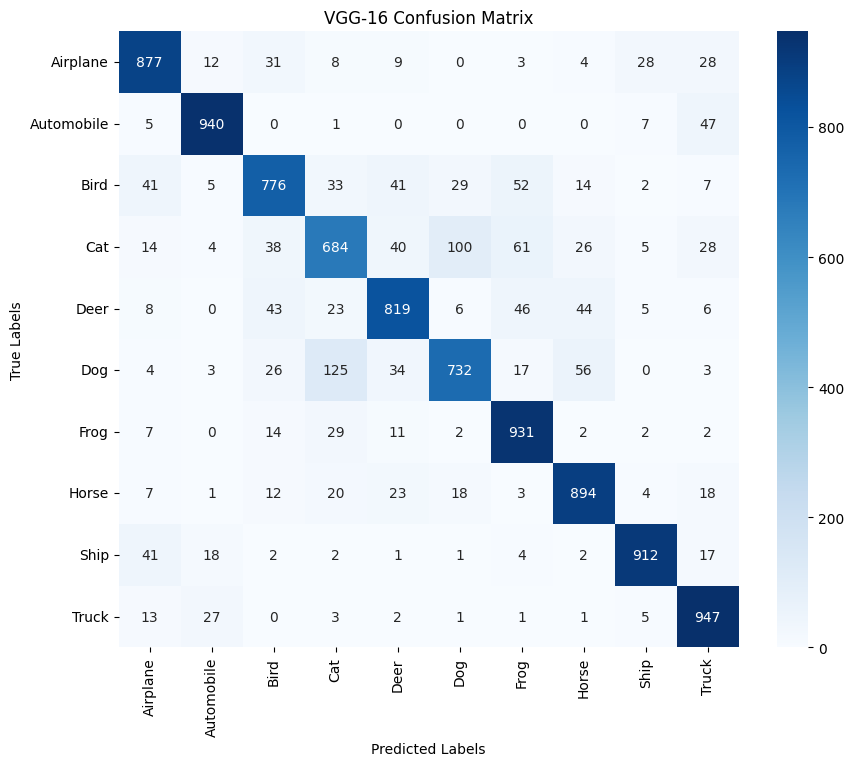

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


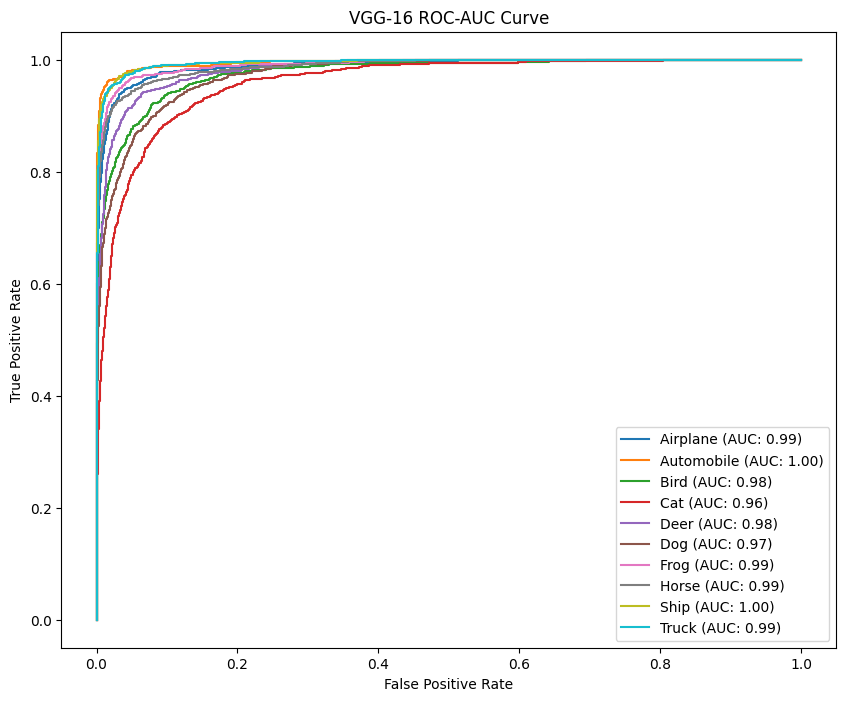

In [ ]:
evaluate_model(vgg16_model, "VGG-16")

## ResNet-18

In [ ]:
print("Training ResNet-18 model...")
history_resnet18 = resnet18_model.fit(train_generator, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)


Training ResNet-18 model...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5624 - loss: 1.2225 - val_accuracy: 0.4835 - val_loss: 1.6456 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6070 - loss: 1.1058 - val_accuracy: 0.5177 - val_loss: 1.4855 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6327 - loss: 1.0327 - val_accuracy: 0.5486 - val_loss: 1.3001 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6593 - loss: 0.9709 - val_accuracy: 0.6726 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6733 - loss: 0.9237 - val_accuracy: 0.6777 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.6852 - loss: 0.8869 - val_accuracy: 0.6319 - val_loss: 1.1380 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms


Evaluating ResNet-18 on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
ResNet-18 Classification Report:
              precision    recall  f1-score   support

    Airplane       0.42      0.52      0.46      1000
  Automobile       0.51      0.83      0.63      1000
        Bird       0.35      0.48      0.40      1000
         Cat       0.43      0.19      0.27      1000
        Deer       0.47      0.28      0.35      1000
         Dog       0.75      0.09      0.16      1000
        Frog       0.81      0.36      0.50      1000
       Horse       0.50      0.63      0.56      1000
        Ship       0.70      0.61      0.65      1000
       Truck       0.39      0.79      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.53      0.48      0.45     10000
weighted avg       0.53      0.48      0.45     10000



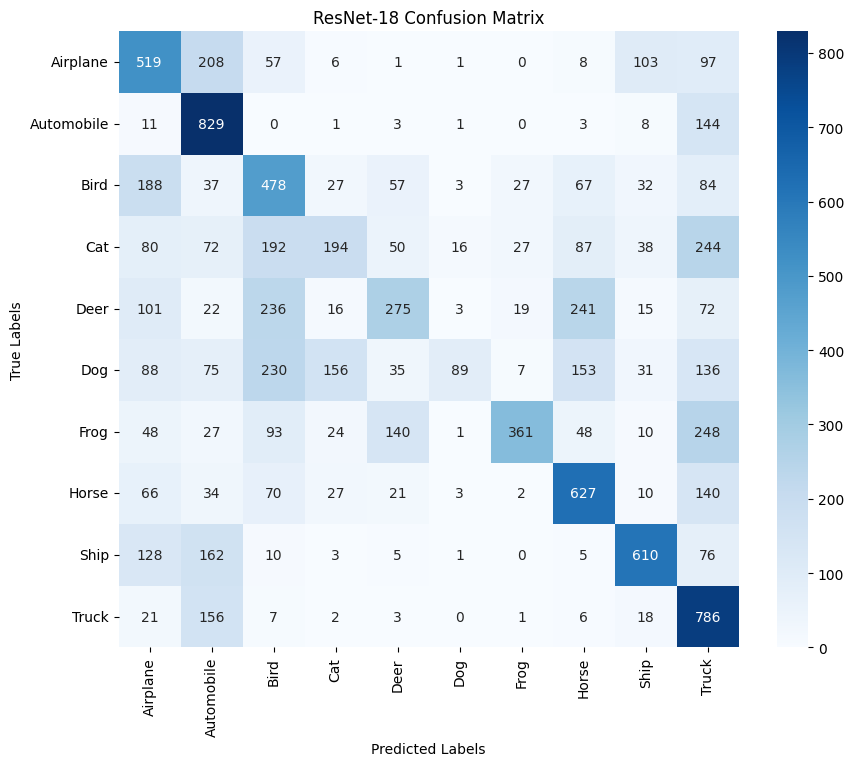

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


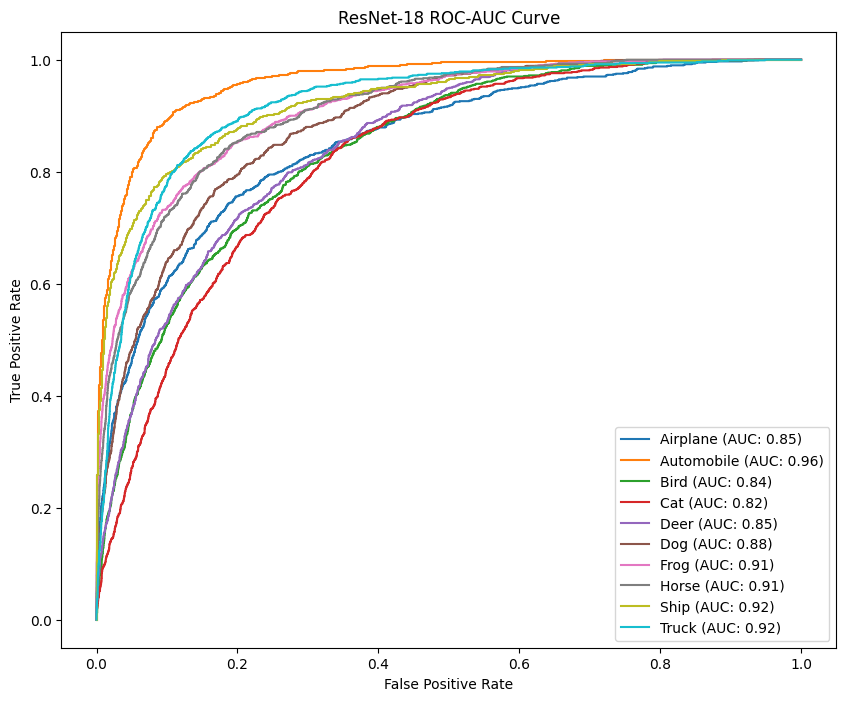

In [ ]:
evaluate_model(resnet18_model, "ResNet-18")

## ResNet-50

In [ ]:
history_resnet50 = resnet50_model.fit(train_generator, epochs=30, validation_data=(x_val, y_val), callbacks = callbacks)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 66ms/step - accuracy: 0.2625 - loss: 2.1177 - val_accuracy: 0.1598 - val_loss: 3.1800 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.3897 - loss: 1.7062 - val_accuracy: 0.1147 - val_loss: 2.4233 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.4186 - loss: 1.6254 - val_accuracy: 0.2514 - val_loss: 2.1702 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.4362 - loss: 1.5743 - val_accuracy: 0.1822 - val_loss: 2.7996 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.4512 - loss: 1.5416 - val_accuracy: 0.1822 - val_loss: 2.7925 - learning_rate: 0.0010
Epoch 6/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4638 - loss: 1.5057
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.4638 - los


Evaluating ResNet-50 on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
ResNet-50 Classification Report:
              precision    recall  f1-score   support

    Airplane       0.58      0.75      0.66      1000
  Automobile       0.67      0.58      0.62      1000
        Bird       0.75      0.22      0.34      1000
         Cat       0.47      0.29      0.36      1000
        Deer       0.47      0.53      0.49      1000
         Dog       0.57      0.40      0.47      1000
        Frog       0.61      0.71      0.66      1000
       Horse       0.45      0.83      0.58      1000
        Ship       0.75      0.62      0.68      1000
       Truck       0.56      0.70      0.62      1000

    accuracy                           0.56     10000
   macro avg       0.59      0.56      0.55     10000
weighted avg       0.59      0.56      0.55     10000



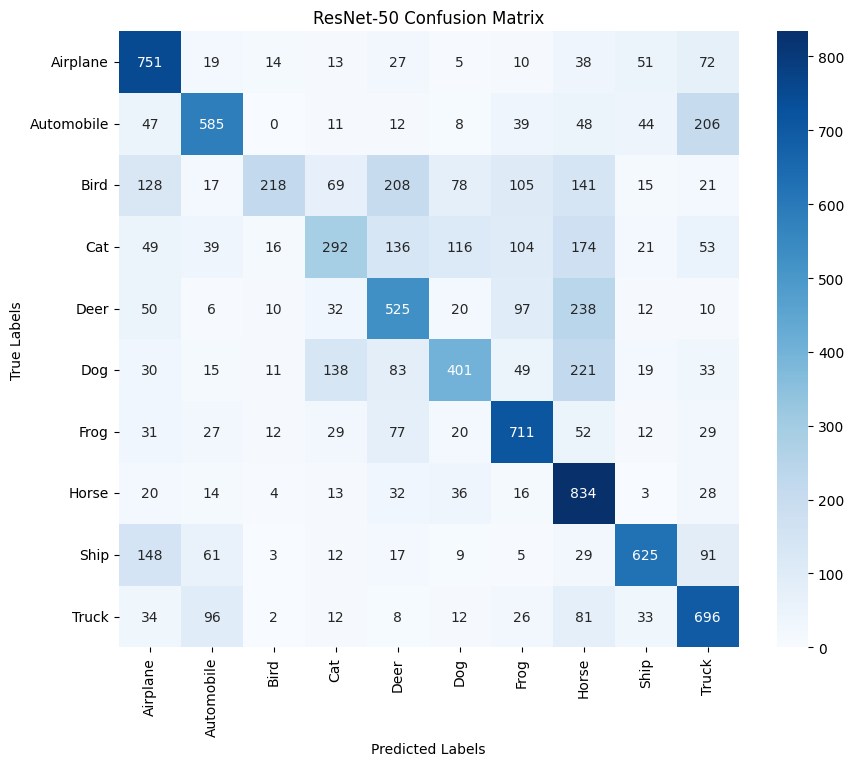

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


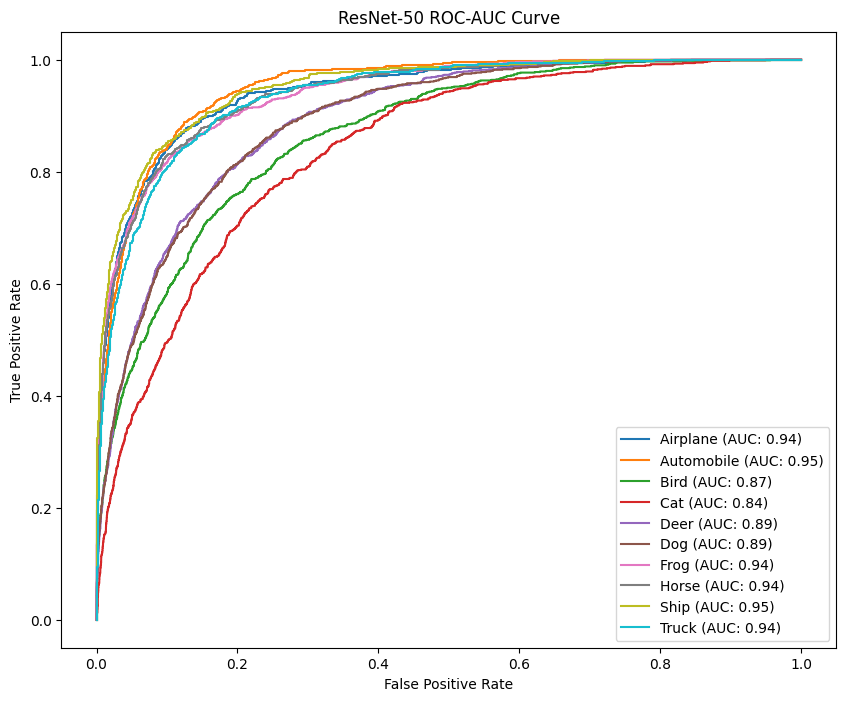

In [ ]:
evaluate_model(resnet50_model, "ResNet-50")

## MobileNet

In [ ]:
print("Training MobileNet model...")
history_mobilenet = mobilenet_model.fit(train_generator, epochs=30, validation_data=(x_val, y_val), callbacks = callbacks)


Training MobileNet model...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 55ms/step - accuracy: 0.4268 - loss: 1.8902 - val_accuracy: 0.6858 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.6784 - loss: 0.9589 - val_accuracy: 0.7203 - val_loss: 0.8921 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.7288 - loss: 0.8124 - val_accuracy: 0.7516 - val_loss: 0.7476 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7440 - loss: 0.7570 - val_accuracy: 0.7336 - val_loss: 0.8375 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.7660 - loss: 0.6904 - val_accuracy: 0.7801 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.7749 - loss: 0.6701 - val_accuracy: 0.7714 - val_loss: 0.6981 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms


Evaluating MobileNet on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MobileNet Classification Report:
              precision    recall  f1-score   support

    Airplane       0.77      0.72      0.75      1000
  Automobile       0.75      0.92      0.83      1000
        Bird       0.72      0.41      0.53      1000
         Cat       0.60      0.33      0.43      1000
        Deer       0.64      0.64      0.64      1000
         Dog       0.70      0.50      0.59      1000
        Frog       0.50      0.92      0.65      1000
       Horse       0.75      0.78      0.77      1000
        Ship       0.81      0.85      0.83      1000
       Truck       0.77      0.83      0.80      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.68     10000
weighted avg       0.70      0.69      0.68     10000



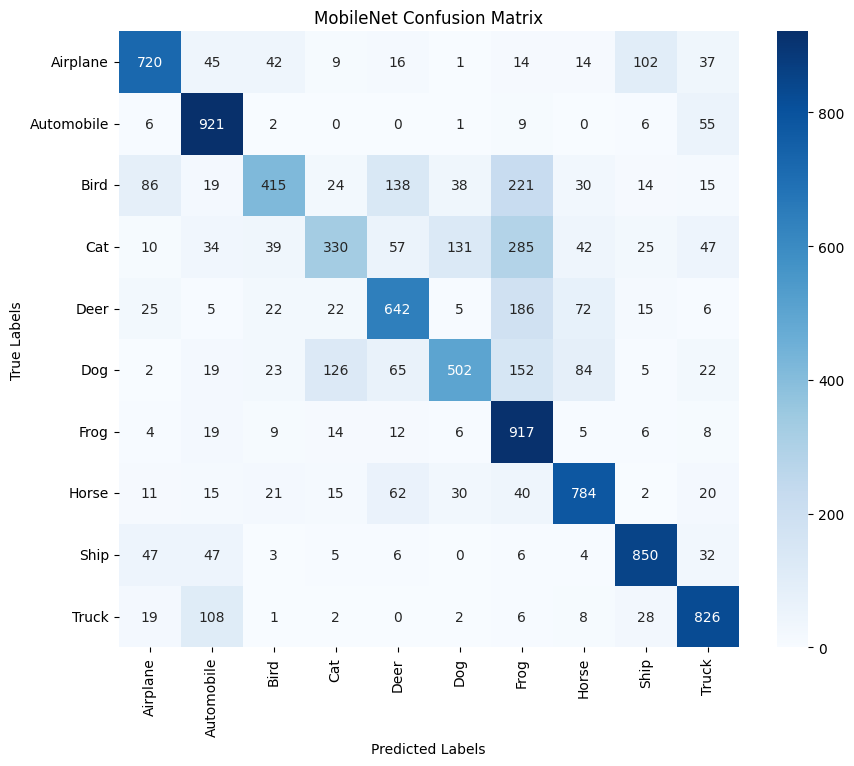

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


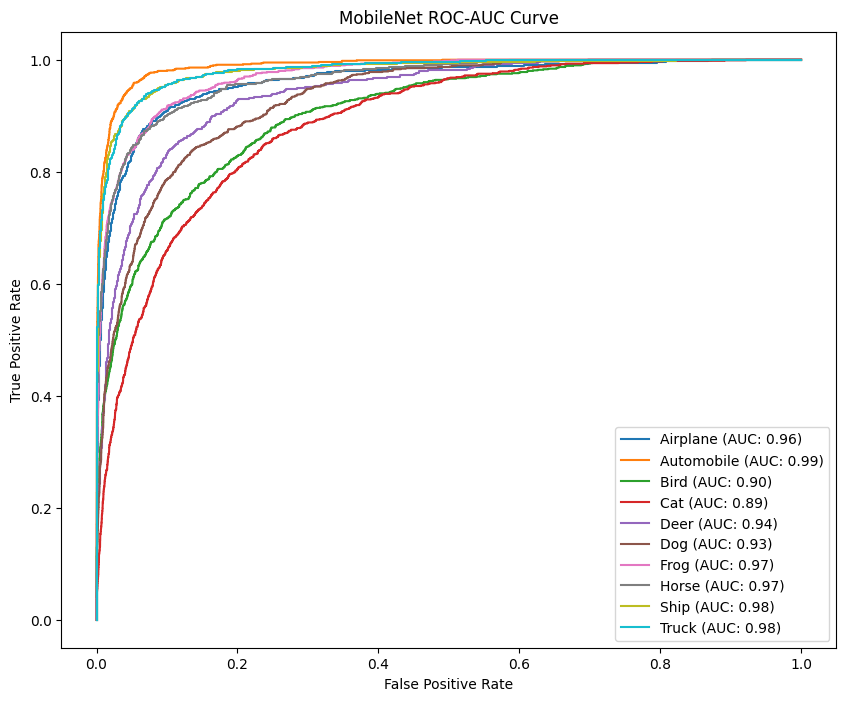

In [ ]:
evaluate_model(mobilenet_model, "MobileNet")